In [216]:
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from TScmap import TScmap
import ftpS3

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [217]:
def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v / vmax, c))
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

whiteblue=generate_cmap(['#000000','#010E5E','#042AA6','#0F7CE0','#1AC7FF','#FFFFFF'])

In [218]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

# 極座標のマップ テスト

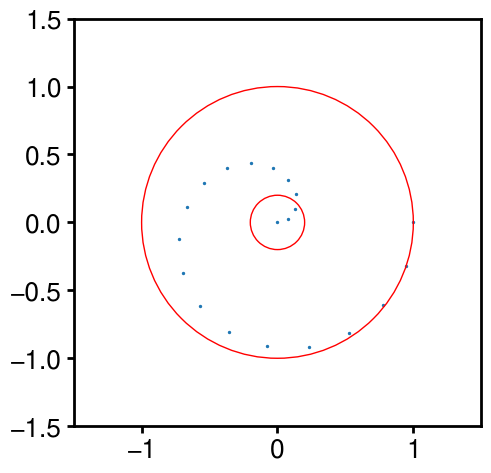

In [219]:
theta = np.linspace(0,90,20)  # colatitude
theta = np.radians(theta)
phi = np.linspace(0,360,20)  # east longitude
phi = np.radians(phi)

r = 1
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)

fontsize = 19
fig, ax = plt.subplots(figsize=(5,5), dpi=100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_aspect('equal')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.scatter(x,y,s=2)

ax.add_patch(patches.Circle(xy=(0,0), radius=0.2, fill=False, ec='r'))
ax.add_patch(patches.Circle(xy=(0,0), radius=1.0, fill=False, ec='r'))

fig.tight_layout()
plt.show()

# STIS観測マップ (北半球)

In [220]:
def load(csvname0):
    df = pd.read_csv(csvname0, sep='\t')
    utc = df.loc[:, 'date']                                 # UTC date
    efplat = df.loc[:, 'lat [deg]'].values                  # EFP latitude [deg]
    efpwlong = df.loc[:, 'wlong [deg]'].values              # EFP System III longitude [deg]
    moons3 = df.loc[:, 'Moon S3 [deg]'].values              # Europa's System III longitude [deg]
    final_phot_ave = df.loc[:, 'spot brightness [kR]']      # EFP brightness [kR]
    annulus_median = df.loc[:, 'local background [kR]']     # local background [kR]
    
    b0_arr = np.zeros(len(final_phot_ave))
    b1_arr = np.zeros(len(final_phot_ave))
    efplat0_arr = np.zeros(len(final_phot_ave))
    efpwlong0_arr = np.zeros(len(final_phot_ave))
    moons30_arr = np.zeros(len(final_phot_ave))
    for i in range(len(final_phot_ave)):
        if final_phot_ave[i] != '0':
            b0_arr[i] = final_phot_ave[i]
            b1_arr[i] = annulus_median[i]
            efplat0_arr[i] = efplat[i]
            efpwlong0_arr[i] = efpwlong[i]
            moons30_arr[i] = moons3[i]
        else:
            continue
    
    return utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr

In [221]:
north_doy = ['14/006_v06', '14/013_v13', '14/016_v12', '22/271_v18', '22/274_v17']
south_doy = ['22/185_v09R', '22/310_v19R', '22/349_v23R']

nbkg_doy = ['14/001_v01', '14/002_v02', '14/005_v05', '14/006_v06', '14/013_v13', '14/016_v12', '22/185_v10', '22/228_v13', '22/271_v18', '22/274_v17', '22/309_v20', '22/349_v24']
sbkg_doy = ['22/140_v03', '22/185_v09', '22/186_v11', '22/229_v14', '22/310_v19', '22/311_v21', '22/349_v23']

In [222]:
hem = 'North'
if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
    bon17 = '0006'
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
    bon17 = '0007'
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

In [223]:
print(satoval['eulat'])

[83.96 85.43 86.88 87.85 87.42 85.94 84.13 82.15 79.98 77.52 74.7  71.65
 68.85 66.52 64.57 62.86 61.32 59.92 58.65 57.5  56.47 55.56 54.77 54.08
 53.51 53.03 52.64 52.34 52.13 52.   51.94 51.96 52.05 52.21 52.44 52.74
 53.1  53.52 54.   54.53 55.12 55.75 56.42 57.13 57.87 58.63 59.42 60.23
 61.07 61.92 62.8  63.7  64.64 65.61 66.62 67.68 68.77 69.87 70.95 71.98
 72.92 73.78 74.57 75.3  76.01 76.73 77.49 78.31 79.21 80.22 81.34 82.58
 83.96]


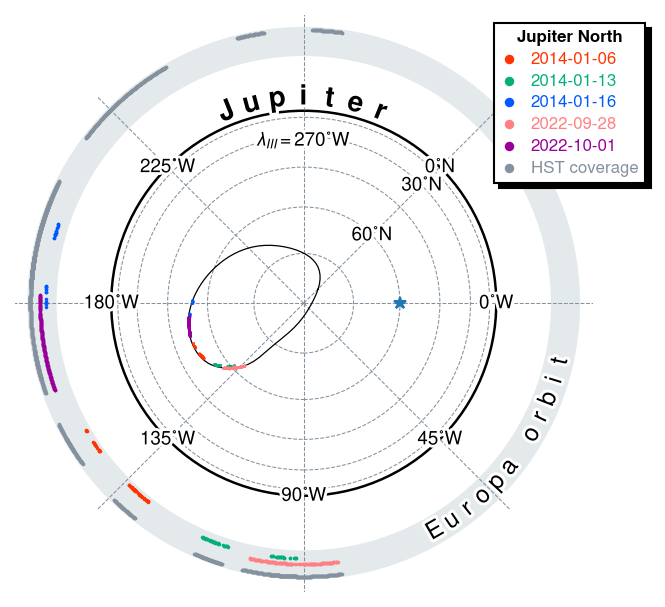

In [302]:
fontsize = 18
fig, ax = plt.subplots(figsize=(5,5), dpi=150)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_aspect('equal')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)

doycolor = [cud4[0], cud4[2], cud4[3]]+[cud4[5], cud4[7]]+[cud4bs[7]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']+['2022-09-28', '2022-10-01']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    # moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]

    # Footprint
    colat = np.radians(90-efplat0_arr)
    elong = np.radians(360-efpwlong0_arr)
    x = np.sin(colat)*np.cos(elong)
    y = np.sin(colat)*np.sin(elong)
    ax.scatter(x, y, s=0.3, marker='.', c=doycolor[i], zorder=10,)
    
    # Satellite - Detection only
    colat = np.radians(90)
    elong = np.radians(360-moons30_arr[idx])
    x = (1.31+0.015*i)*np.sin(colat)*np.cos(elong)
    y = (1.31+0.015*i)*np.sin(colat)*np.sin(elong)
    ax.scatter(x, y, s=2.0, marker='.', c=doycolor[i], zorder=10, label=doyname[i])

for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    # moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]

    # Satellite - All
    colat = np.radians(90)
    elong = np.radians(360-moons30_arr)
    x = (1.42)*np.sin(colat)*np.cos(elong)
    y = (1.42)*np.sin(colat)*np.sin(elong)
    if i==0:
        ax.scatter(x, y, s=2.0, marker='.', c=cud4bs[7], zorder=11, label='HST coverage')
    else:
        ax.scatter(x, y, s=2.0, marker='.', c=cud4bs[7], zorder=11,)

# 緯度のグリッド (15 deg)
for deg in np.arange(15,90,15):
    ax.add_patch(patches.Circle(
        xy=(0,0), radius=np.sin(np.radians(90-deg)), fill=False, ec=cud4bs[7],
        linestyle='dashed', linewidth=0.5,
        ))
for deg in np.arange(0,90,30):
    ax.text(
        np.sin(np.radians(90-deg))*np.cos(np.radians(360-315)),
        np.sin(np.radians(90-deg))*np.sin(np.radians(360-315)),
        str(deg)+'˚N',
        size=fontsize*0.5,
        # rotation=deg,
        color='k',
        horizontalalignment='center',
        verticalalignment='center',
        path_effects=[pe.withStroke(linewidth=2.8, foreground='white')]
    )

# 経度のグリッド (45 deg)
for deg in np.arange(0,360,45):
    ax.plot(
        [0, 1.52*np.cos(np.radians(360-deg))],
        [0, 1.52*np.sin(np.radians(360-deg))],
        linestyle='dashed', linewidth=0.5, color=cud4bs[7]
    )
for deg in np.arange(0,270,45):
    ax.text(
        1.0*np.cos(np.radians(360-deg)),
        1.0*np.sin(np.radians(360-deg)),
        str(deg)+'˚W',
        size=fontsize*0.5,
        # rotation=deg,
        color='k',
        horizontalalignment='center',
        verticalalignment='center',
        path_effects=[pe.withStroke(linewidth=2.8, foreground='white')]
    )
ax.text(
    0.85*np.cos(np.radians(360-270)),
    0.85*np.sin(np.radians(360-270)),
    r'$\lambda_{III}=$'+str(270)+'˚W',
    size=fontsize*0.5,
    # rotation=deg,
    color='k',
    horizontalalignment='center',
    verticalalignment='center',
    path_effects=[pe.withStroke(linewidth=2.8, foreground='white')]
)

# Edge of Jupiter
ax.add_patch(patches.Circle(
    xy=(0,0), radius=1.0, fill=False, ec='k', linewidth=1.2
    ))
letter = 'Jupiter'
for i in range(len(letter)):
    deg = 360-(248+7.3*i)
    ax.text(
        1.069*np.cos(np.radians(deg)),
        1.069*np.sin(np.radians(deg)),
        letter[i],
        weight='bold',
        size=fontsize*0.74,
        rotation=deg-90,
        color='k',
        horizontalalignment='center',
        verticalalignment='center',
        path_effects=[pe.withStroke(linewidth=2.9, foreground='white')]
    )

# Europa軌道
ax.add_patch(patches.Circle(
    xy=(0,0), radius=1.36, fill=False, ec='#E4E9EB', linewidth=14
    ))
letter = 'Europa orbit'
for i in range(len(letter)):
    deg = 360-(60-4.3*i)
    ax.text(
        1.365*np.cos(np.radians(deg)),
        1.365*np.sin(np.radians(deg)),
        letter[i],
        size=fontsize*0.64,
        rotation=deg+90,
        color='k',
        horizontalalignment='center',
        verticalalignment='center',
        path_effects=[pe.withStroke(linewidth=2.9, foreground='white')]
    )

# JRM33 reference line
ax.plot(
    np.sin(np.radians(90-satoval['eulat']))*np.cos(np.radians(360-satoval['euwlon'])),
    np.sin(np.radians(90-satoval['eulat']))*np.sin(np.radians(360-satoval['euwlon'])),
    linewidth=0.6, color='k'
)

# 位置の確認用 (緯度60, 東経0)
ax.plot(
    np.sin(np.radians(90-60))*np.cos(np.radians(0)),
    np.sin(np.radians(90-60))*np.sin(np.radians(0)),
    marker='*'
)

# 縦軸と横軸を全て削除する
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params('x', length=0, which='major')   # 目盛りを消す
ax.tick_params('y', length=0, which='major')   # 目盛りを消す
plt.setp(ax.get_xticklabels(), visible=False)  # ラベルを消す
plt.setp(ax.get_yticklabels(), visible=False)  # ラベルを消す


legend_fsize = fontsize*0.45
legend1 = ax.legend(loc='upper center',
                    ncol=1,
                    markerscale=5,
                    bbox_to_anchor=(0.96, 1.0),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=1,)
legend1.set_title('Jupiter North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax, legend1, dx=0.005, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color((doycolor)[i])
    i += 1


plt.show()